# "Penney's Game"
> "A naturally-occurring rock-paper-scissors"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [probability, simulation, monte-carlo, penneys-game, counterintuitive]
- hide: false
- image: images/pile-of-pennies.jpg
- search_exclude: false
- metadata_key1: simulation
- metadata_key2: probability

# Penney's Game

The setup: you're playing a game with a friend involving coin flips. Both you and your friend choose a sequence of three coin flips; let's say that you choose THH, and your friend chooses HHT. A neutral referee flips a single coin repeatedly until one of you encouters the sequence you're waiting for. So, for instance, if the sequence of coin flips is

<p style="text-align: center;">THTTHTH<font color = "red">THH</font></p>

then you would win the game, because THH occurred before HHT ever did. The question is: **is this a fair game?** Or, does one player have an advantage over the other?

# The Incorrect Answer

This a great question to trip up some people who know *some* probability. When I first heard this question, the answer seemed obvious -- **of course it's fair!** After all, I knew that in a sequence of of three isolated coin flips, both THH and HHT (and any other sequence of coin flips) had a $\frac 1 2 \cdot \frac 1 2 \cdot \frac 1 2 = \frac 1 8$ chance of appearing. That claim is of course true, but it's a little more satisfying to *see* it with some simulations:

In [1]:
#collapse_output

library(ggplot2)
library(dplyr)
library(tidyr)
library(stringr)
options(repr.plot.width=10, repr.plot.height=6)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




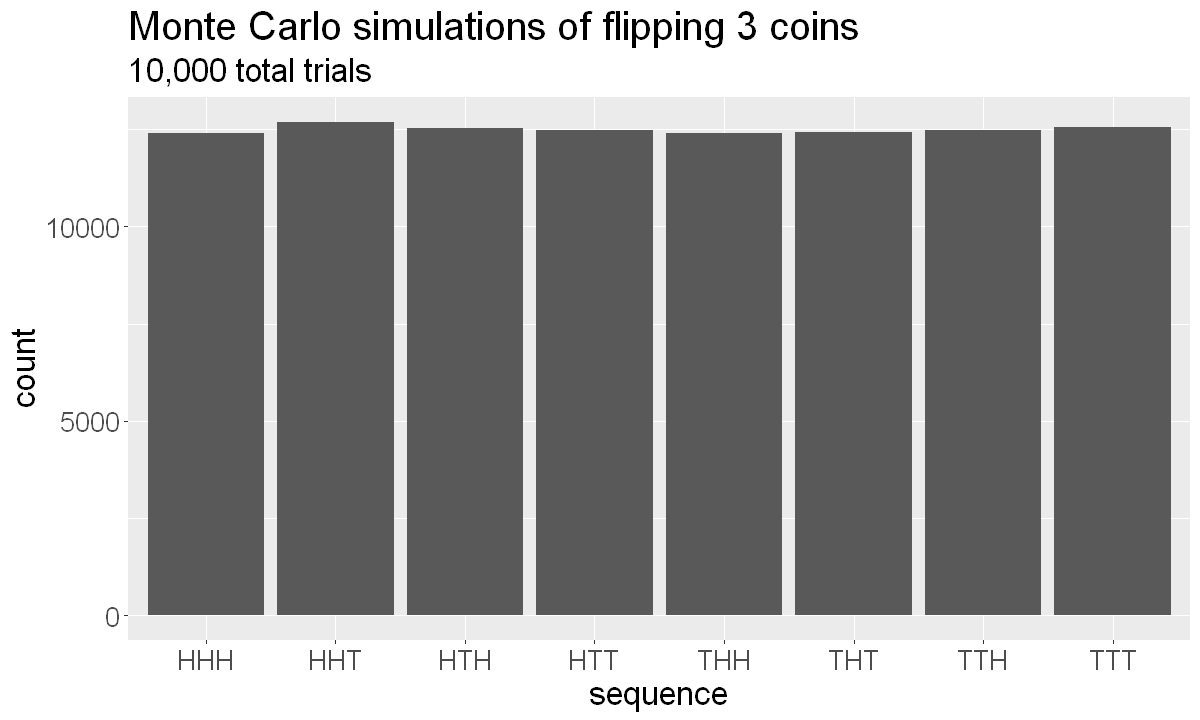

In [2]:
# the first line makes a vector of 10,000 strings like "HTH" or "TTT"

replicate(1e5, paste0(sample(c("H", "T"), 3, replace = T), collapse = "")) %>%
  tibble(sequence = .) %>%
  arrange(sequence) %>%
  ggplot(aes(x = sequence)) +
    geom_bar(stat = "count") +
    labs(title = "Monte Carlo simulations of flipping 3 coins",
         subtitle = "10,000 total trials") +
    theme(text = element_text(size = 20))

As expected, we encounter each of the 8 distinct sequences with approximately equal frequency, so we haven't gone astray yet. The problem arises when we try to extend that logic to the actual game described up above; in this case, we're waiting for one of two sequences to appear instead of just stopping after 3 flips and logging the outcomes. Here are the simulations for the THH vs. HHT game we originally described:

In [3]:
# This function will take two strings of coin flips and return the one that occurs
# first in a long sequence of coin flips.

penney <- function(p1, p2){         # p1 and p2 are strings like "HHT", "HTT"
  p1 <- unlist(str_split(p1, ""))   # split string into vector of length 3
  p2 <- unlist(str_split(p2, ""))
  flips <- sample(c("H", "T"), 3, replace = T) 
    # initialize flips with first 3 coin flips
    
    # on each pass of the while loop, push the first two coins forward in the list,
    # then sample a new coin for the third one; for instance, HTH becomes TH? where
    # ? is the result of a new coin flip
    
  while(!all(p1 == flips) & !all(p2 == flips)){
    flips[1:2] <- flips[2:3]
    flips[3] <- sample(c("H", "T"), 1)
  }
    
  ifelse(all(p1 == flips), 
         paste0(p1, collapse = ""), 
         paste0(p2, collapse = ""))  # output winning sequence
}

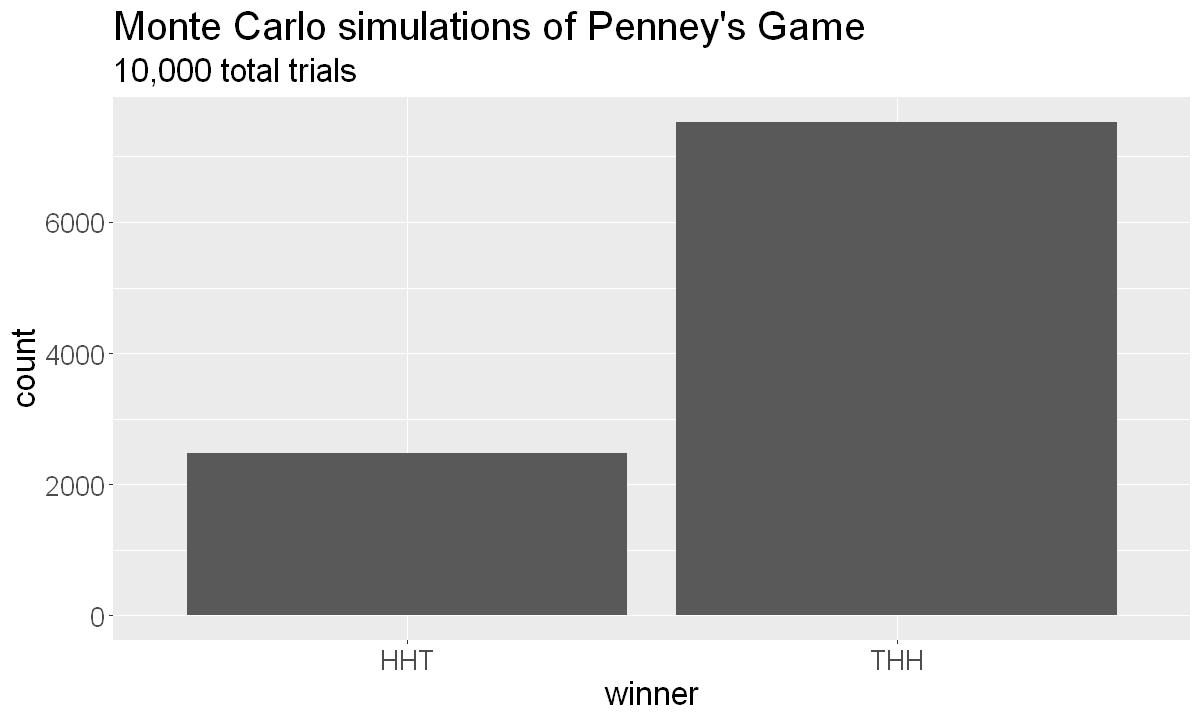

In [4]:
replicate(10000, penney("HHT", "THH")) %>%
  tibble(winner = .) %>%
  arrange(winner) %>%
  ggplot(aes(x = winner)) +
    geom_bar(stat = "count") +
    labs(title = "Monte Carlo simulations of Penney's Game",
         subtitle = "10,000 total trials") +
    theme(text = element_text(size = 20))

It is immediately very clear that this is **not** a fair game.

# The Correct Answer

Once we see that the game is not fair, we should ask why. For these particular two coin flips, there's a good argument of why HHT should beat THH just one out of four times: the only way that HHT can win is if the *first two* coin flips are both heads. Otherwise, there's some first occurrence of two H's in the sequence, and that first occurrence is necessarily preceded by a T.  The probability that this occurs is $\frac 1 2 \cdot \frac 1 2 = \frac 1 4$, which is why HHT won about 2500 times out of our 10,000 simulations above.

Now that we see why THH should usually beat HHT, what about all the possible head-to-head matchups? To see, we'll simulate every possible matchup of all three sequences and generate a heatmap of the results.

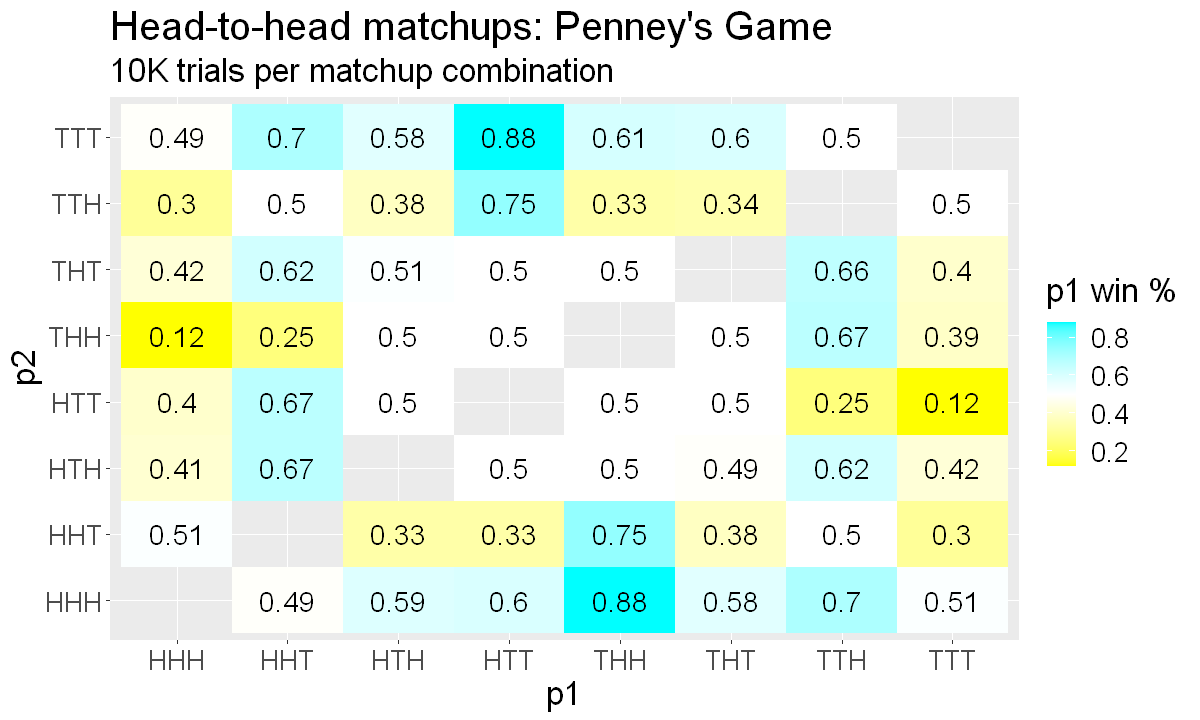

In [10]:
# this helper function takes two coin sequences, simulates Penney's game many
# times, and returns the proportion of times the *first* sequence wins
penney_wrapper <- function(p1, p2){
  mean(replicate(1e4, penney(p1, p2)) == p1)
}

results <-
  c("HHH", "HHT", "HTH", "HTT", "THH", "THT", "TTH", "TTT") %>%
  combn(2) %>%
  t() %>%
  as.data.frame()
# makes a data frame with all combinations of sequences

names(results) <- c("p1", "p2")

results <- 
  results %>%
  rowwise() %>%
  mutate(p1_wins = penney_wrapper(p1, p2)) %>%
  mutate(p1_wins = round(p1_wins, 2))

results <-
  tibble(
    p1 = results$p2,
    p2 = results$p1,
    p1_wins = 1 - results$p1_wins
  ) %>%
    bind_rows(results)
# since we simulated only half of the matchups, we can just mirror
# the results to flip p1 and p2 rather than resimulating

results %>%
  ggplot(aes(x = p1, y = p2, fill = p1_wins)) +
    geom_tile() +
    geom_text(aes(label = p1_wins), size = 6) +
    scale_fill_gradient2(low = "yellow", mid = "white", 
                         high = "cyan", midpoint = 0.5) +
    labs(title = "Head-to-head matchups: Penney's Game",
         subtitle = "10K trials per matchup combination",
         fill = "p1 win %") +
    theme(text = element_text(size = 20))

This chart reveals some pretty fascinating truths about Penney's Game. Here are some of the things we learn:

### 1. On the whole, Penney's Game is certainly not fair.

We can see that some matchups have...
  * slight advantages, like THH over TTT
  * moderate advantages, like HHT over TTT
  * overwhelming advantages, like HTT over TTT
  
### 2. Yet, fair games do exist within Penney's Game.

No matter which sequence Player 1 picks, Player 2 can pick something that has a $50\%$ chance of beating it. If the two players of the game *want* the game to be fair, they can choose in a way to make it so.

### 3. Rock-Paper-Scissors

On the other hand, if Player 1 picks their sequence first, then *no matter what they have picked*, Player 1 can pick something that has an advantage over it. This is almost a probabilistic version of rock-paper-scissors; *everything* is beaten by *something*.

If Player 1 picks... | Then Player 2 should pick...
---|---
HHH|THH
HHT|THH
HTH|HHT
HTT|HHT
THH|TTH
THT|TTH
TTH|HTT
TTT|HTT

The [easy way to remember](https://en.wikipedia.org/wiki/Penney%27s_game#Analysis_of_the_three-bit_game) what Player 2 should pick is: if Player 1 picks $123$, then Player 2 should pick $\overline 212$, where $\overline 2$ denotes the opposite of $2$.

A logical consequence of this is that there are cycles of things that generally defeat each other. For instance:

* <font color = "blue">HHT</font> usually loses to THH,
* which usually loses to TTH, 
* which usually loses to HTT, 
* which usually loses to <font color = "blue">HHT</font>.

Thus, we have an interesting example of a nontransitive game occurring in the wild.

### 4. Not all sequences are created equally

Although every sequence is beaten by something, not every sequence beats something else; TTT and HHH have no advantage over any other sequence. The best case scenario for those sequences is a fair game.

### 5. Limits of simulations

This turns out to be a decent advertisement for the limits of simulations (as compared to theoretical approaches) as well. Generally, simulations are quite good at conveying big-picture ideas, like the takeaways we identified above. Yet, simulations are not as well-suited to identifying small differences between things. For instance, the theoretical win probability of HHH over THT is $5/12 \approx 0.4167$, and the theoretical win probability of HHH over HTT is $2/5 = 0.40$. (See [Further Reading](#further-reading) for details.) Yet in the heatmap above, these two values are close enough that it is not obvious they represent different numbers under the hood. This can be solved with more replications, of course, but that is an expensive solution that scales poorly as numbers get closer together.

# To be continued....

So far, we've seen that Penney's Game is *not* fair and that it contains a nontransitive game inside it. However, this isn't the end of the story; even if we remove the competitive aspect of the game and just focus on what happens with *one* player, the game still doesn't behave like you might expect. 

# Further Reading

You can find a theoretically-based explanation of Penney's Game, along with a chart of *exact* win probabilities (rather than approximations rendered from simulations), [here](https://plus.maths.org/content/os/issue55/features/nishiyama/index).